In [93]:
#pip install mercury

In [94]:
# import mercury as mr

In [95]:
# mr.PDF("QNN - Technical Writeup.pdf")

**Quanvolutional Neural Networks**

1. PennyLane (pennylane): A library for quantum machine learning that allows defining and running quantum circuits.
2. TensorFlow (tensorflow): A popular library for building and training neural networks.
3. NumPy (numpy): Used for numerical operations.
4. Matplotlib (matplotlib): Used for plotting training and validation metrics.
5. Keras (keras): High-level API for building and training neural networks, included in TensorFlow.

**Gist** : The below code demonstrates a hybrid classical-quantum neural network approach. It uses a reduced version of the MNIST dataset to train a model that includes a quantum layer, which is evaluated within a TensorFlow/Keras framework. While the quantum component is simplified here for demonstration, it showcases how quantum circuits can be integrated into classical machine learning pipelines.

In [96]:
# !pip install pennylane
# !pip install tensorflow

In [97]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# # from silence_tensorflow import silence_tensorflow
# silence_tensorflow()


**Load and Preprocess MNIST Dataset**

1. Dataset Loading: MNIST data is loaded with keras.datasets.mnist.load_data(), providing images and labels of handwritten digits.
2. Reduce Dataset Size: Only a small subset of data is used for quicker computations.
3. Normalization: Pixel values are normalized to the range [0, 1].
4. Dimension Expansion: Added a channel dimension to match the expected input shape for CNNs (though not used further in this script).

In [98]:
# Load and preprocess MNIST dataset
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset
n_epochs = 20
n_layers = 4

mnist_dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

# Reduce dataset size
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

# Normalize pixel values within 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add extra dimension for convolution channels
x_train = np.array(x_train[..., tf.newaxis], requires_grad=False)
x_test = np.array(x_test[..., tf.newaxis], requires_grad=False)


**Feature Reduction**
1. Images are flattened and reduced to only the first 4 features to fit the input dimension of the quantum circuit. This is a major simplification for demonstration purposes.

In [99]:
# Reduce features to match quantum circuit's requirements
# def feature_reduction(x):
#     # Flatten the images and use only the first 4 features
#     x_flat = x.reshape(x.shape[0], -1)  # Flatten the images
#     return x_flat[:, :4]

# x_train_reduced = feature_reduction(x_train)
# x_test_reduced = feature_reduction(x_test)


## Quantum Preprocessing of Images (train & test both) 

In [100]:
SAVE_PATH = "./quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [101]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 0C2A-EB53

 Directory of C:\Users\gupta\Downloads

16-03-2024  09.33 PM           587,854 (Week 16, CC, PI) Statistics Recall Session [Hands-On _ Live Coding _ Tutorial Session] .docx
08-08-2024  12.17 AM    <DIR>          .
07-08-2024  11.24 PM    <DIR>          ..
07-08-2024  10.14 PM    <DIR>          .ipynb_checkpoints
17-03-2024  08.48 PM            29,402 1_Hands_on_Using_ChatGPT_or_Google_Gemini_with_Python_for_real_world_tasks.ipynb
17-03-2024  08.48 PM            74,376 1_Hands_on_Using_ChatGPT_or_Google_Gemini_with_Python_for_real_world_tasks_solutions.ipynb
25-07-2024  07.33 AM        61,227,577 18-06sc-fall-2011.zip
14-07-2024  07.35 PM           321,861 2.1 a1.pdf
14-07-2024  09.51 PM           143,446 2.3 QNickel - Quiz - Deutsch Jozsa and Bernstein Vazirani_ Womanium Quantum+AI 2024.pdf
14-07-2024  10.02 PM           199,997 2.6 QNickel - Quiz - Grover's Search_ Womanium Quantum+AI 2024.pdf
07-08-2024  07.58 PM      

# Define Quantum device and Quantum Circuit

In [102]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

the image is divided into squares of 
 pixels;
each square is processed by the quantum circuit;
the 
 expectation values are mapped into 
 different channels of a single output pixel.
::: {.note} ::: {.title} Note :::

This process halves the resolution of the input image. In the standard language of CNN, this would correspond to a convolution with a 
 kernel and a stride equal to 
. :::

In [103]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [104]:
if PREPROCESS == True:
    q_x_train = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_x_train.append(quanv(img))
    q_x_train = np.asarray(q_x_train)

    q_x_test = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_test):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_x_test.append(quanv(img))
    q_x_test = np.asarray(q_x_test)



Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


In [105]:
# Save pre-processed images
np.save(SAVE_PATH + "q_x_train.npy", q_x_train)
np.save(SAVE_PATH + "q_x_test.npy", q_x_test)


# Load pre-processed images
q_x_train = np.load(SAVE_PATH + "q_x_train.npy")
q_x_test = np.load(SAVE_PATH + "q_x_test.npy")

In [106]:
q_x_train.shape

(50, 14, 14, 4)

**One-Hot Encoding**

1. Labels are converted to a one-hot format suitable for classification tasks, where each label is represented as a vector of length 10.

In [107]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)  # Ensure shape is (n_train, 10)
y_test = to_categorical(y_test, 10)    # Ensure shape is (n_test, 10)


In [108]:
y_train.shape

(50, 10)

**Define Quantum Circuit**

1.A quantum circuit is defined using PennyLane. It uses angle embedding and entangling layers to process the inputs and weights. The expectation value of **PauliZ(0)** is used as the output.

In [109]:
# Define a quantum circuit
# def qnn_circuit(inputs, weights):
#     qml.templates.AngleEmbedding(features=inputs, wires=range(4))
#     qml.templates.BasicEntanglerLayers(weights, wires=range(4))
#     return qml.expval(qml.PauliZ(0))


**Create Quantum Device**

1. A quantum device with 4 qubits is created using PennyLane’s default simulator.

In [110]:
# Create a quantum device
# dev = qml.device("default.qubit", wires=4)


**Define Custom Keras Layer for Quantum Computation**

**QuantumLayer Class**: A custom Keras layer is created to handle quantum computations. It includes:
1. Weights Initialization: Trainable parameters for the quantum circuit.
2. Call Method: Converts inputs and weights to tensors, evaluates the quantum circuit, and reshapes the result.

In [111]:
# class QuantumLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(QuantumLayer, self).__init__(**kwargs)
#         # Initialize weights as trainable parameters
#         self._weights = self.add_weight(
#             shape=(4, 4),  # Adjust shape to match the circuit requirements
#             initializer='random_normal',
#             trainable=True,
#             name='quantum_weights'
#         )

#     def call(self, inputs):
#         # Ensure inputs are in the correct shape and type
#         inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
#         weights = tf.convert_to_tensor(self._weights, dtype=tf.float32)

#         # Define a quantum node
#         @qml.qnode(dev, interface='tf')
#         def quantum_node(inputs, weights):
#             return qnn_circuit(inputs, weights)
        
#         # Get results from quantum node
#         result = quantum_node(inputs, weights)
        
#         # Convert the result back to a TensorFlow tensor and ensure correct shape
#         return tf.reshape(result, (-1, 1))  # Ensure output shape is [batch_size, 1]


**Define and Compile the Model**
- Model Definition: A simple sequential model is defined with:
 1. Input Layer: Matches the input shape of the reduced features.
 2. QuantumLayer: Integrates the quantum circuit into the model.
 3. Dense Layer: A softmax layer for classification with 10 output neurons.
- Compilation: The model is compiled using Adam optimizer and categorical crossentropy loss function.

In [112]:
# Define the model
def create_qnn_model():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    return model

# Create and compile the model
q_model = create_qnn_model()
q_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


**Train and Evaluate the Model**

1. Training: The model is trained for a specified number of epochs with a batch size of 4 and a validation split of 20%.
2. Evaluation: The model is evaluated on the test set to obtain accuracy.

In [117]:
# Train the model and save history
q_history = q_model.fit(q_x_train, y_train, epochs=n_epochs, batch_size=4, verbose=2, validation_data=(q_x_test, y_test),)

# Evaluate the model
loss, accuracy = q_model.evaluate(q_x_test, y_test)
print(f'Test accuracy: {accuracy}')

Epoch 1/20
13/13 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0915 - val_accuracy: 0.6000 - val_loss: 1.1305
Epoch 2/20
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0878 - val_accuracy: 0.6000 - val_loss: 1.1274
Epoch 3/20
13/13 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0844 - val_accuracy: 0.6000 - val_loss: 1.1244
Epoch 4/20
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0811 - val_accuracy: 0.6000 - val_loss: 1.1216
Epoch 5/20
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0780 - val_accuracy: 0.6000 - val_loss: 1.1189
Epoch 6/20
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0752 - val_accuracy: 0.6000 - val_loss: 1.1163
Epoch 7/20
13/13 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0725 - val_accuracy: 0.6000 - val_loss: 1.1139
Epoch 8/20
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0699 - val_accuracy: 0.6000 - val_loss: 1.1115
Epoch 9/20
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0675 - val_accuracy: 0.6000 - val_loss: 1.1093
Epoch 10/20
13/13 

**Plot Training and Validation Metrics**
1. The training and validation loss and accuracy are plotted to visualize the model’s performance over epochs.

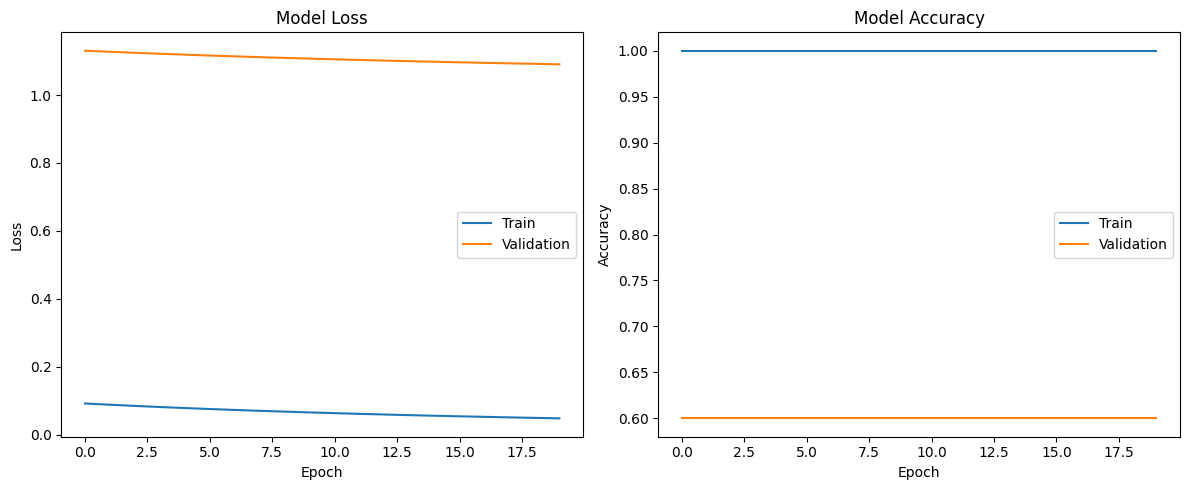

In [118]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(q_history.history['loss'])
plt.plot(q_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(q_history.history['accuracy'])
plt.plot(q_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()
